In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import time

En este notebook lo que vamos a hacer es crear un clasificador sobre el dataset del MNIST para prácticar como introducción a PyTorch.

# Carga del dataset

Hay muchos datasets incluídos dentro de ```torchvision.datasets```, así que resulta fácil cargarlos. Todos se implementan como subclases de ```torch.utils.data.Dataset```, así que se pueden pasar a un ```torch.utils.data.DataLoader```. Por defecto el dataset lo carga como imágenes en formato ```PIL``` así que tenemos que aplicarle una transformación para convertirlo en tensores.

In [2]:
mnist_train = torchvision.datasets.MNIST(root = "/MNIST", download = True, train = True, transform = torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root = "/MNIST", download = True, train = False, transform = torchvision.transforms.ToTensor())
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /MNIST
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /MNIST
     Split: Test
     StandardTransform
 Transform: ToTensor())

Ahora que hemos cargado el dataset tenemos que meterlo en un ```DataLoader``` para poder pasarselo cómodamente a los modelos. Lo que hace es combinar un dataset y un sampler y nos permite iterar sobre el dataset.

In [3]:
train = torch.utils.data.DataLoader(mnist_train, batch_size = 64, shuffle = True)
test = torch.utils.data.DataLoader(mnist_test, batch_size = 64, shuffle = True)
train, test

(<torch.utils.data.dataloader.DataLoader at 0x157e220db50>,
 <torch.utils.data.dataloader.DataLoader at 0x157e220daf0>)

Una vez hemos creado el ```DataLoader``` podemos iterar sobre él y nos devuelve los elementos del dataset en los batches que hemos especificado. Es importante recordar que al iterar nos devuelve dos tensores, el X y el Y agrupados en una lista.

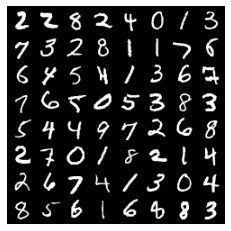

In [4]:
for X, Y in train:
    grid = torchvision.utils.make_grid(X, nrow = int(np.sqrt(len(X))))
    plt.imshow(grid.permute(1,2,0)) #Hay que permutar porque matplotlib espera los canales al final y torch los pone al principio
    plt.axis('off')
    plt.show()
    break

# Creando el primer modelo

La forma típica de trabajar con PyTorch es heredando de la clase ```torch.nn.Module```, pero también tienen una clase ```torch.nn.Sequential``` que funciona de forma muy similar a TF/Keras, así que vamos a empezar probando eso y luego ya lo hacemos con subclassing:

In [5]:
for X, Y in train:
    print(X.shape)
    break

torch.Size([64, 1, 28, 28])


In [6]:
import torch.nn as nn

In [7]:
architecture = [
    nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3),
    nn.MaxPool2d(kernel_size = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
    nn.MaxPool2d(kernel_size = 2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
    nn.Softmax()
]

In [8]:
model = nn.Sequential(*architecture)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=None)
)


In [9]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.max(axis = -1)[-1]
    div = y_true / y_pred
    res = np.where(div == 1, 1, 0)
    return res.sum() / len(y_true)

## Training Loop

In [11]:
epochs = 5
losses = []
acc = []

time_i = time.time()

for epoch in range(epochs):
    for X, Y in train:
        pred = model(X)
        loss = loss_fn(pred, Y)

        #Calculamos los gradientes
        loss.backward()

        #Actualizamos los pesos con el optimizador
        optim.step()

        #Volvemos a hacer 0 los gradientes para que no se acumulen
        optim.zero_grad()

    #Guardamos el error y la precisión después de cada época
    losses.append(loss)
    acc.append(accuracy(Y, pred))

print(f"Tiempo total de entrenamiento: {time.time() - time_i }s.")

Tiempo total de entrenamiento: 233.76529049873352s.


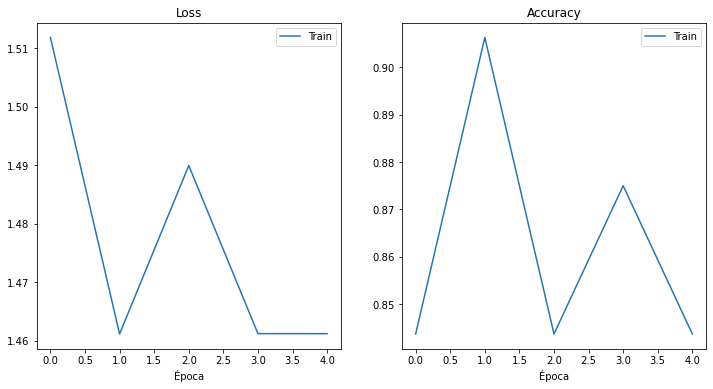

In [12]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(acc, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()

## Ahora en GPU
La única diferencia es que hay que mover el modelo y el dataset a la GPU. Como estamos usando un ```DataLoader```, no podemos moverlo directamente a la GPU si no que iremos moviendo los batches progresivamente. Lo primero que hay que hacer es localizar nuestra GPU:

In [13]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Elige GPU si está disponible y CPU si no
device

device(type='cuda', index=0)

In [14]:
model = nn.Sequential(*architecture)
model.to(device) #Hay que moverlo a la GPU antes de crear el optimizador, porque el optimizador tiene como input lo parámetros del modelo
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=None)
)


In [15]:
optim = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.argmax(axis = -1)
    div = y_true / y_pred
    res = torch.where(div == 1, 1, 0)
    return res.sum() / len(y_true)

In [17]:
train_iter = iter(train)

In [18]:
x_test, y_test = train_iter.next()

In [19]:
epochs = 30
losses = []
accs = []

time_i = time.time()

for epoch in range(epochs):
    loss_epoch = []
    accs_epoch = []
    for X, Y in train:
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss = loss_fn(pred, Y)

        #Calculamos los gradientes
        loss.backward()

        #Actualizamos los pesos con el optimizador
        optim.step()

        #Volvemos a hacer 0 los gradientes para que no se acumulen
        optim.zero_grad()

        #Guardamos el error y la precisión después de cada batch
        loss_epoch.append(loss)
        accs_epoch.append(accuracy(Y, pred))
    #Y los guardamos finalmente por época
    losses.append(torch.mean(torch.Tensor(loss_epoch)))
    accs.append(torch.mean(torch.Tensor(accs_epoch)))
    #Printeamos para ir viendo cómo va
    print(f"Época {epoch+1} -> Loss: {losses[-1]} / Accuracy: {accs[-1]}")
print(f"Tiempo total de entrenamiento: {time.time() - time_i} s.")

Época 1 -> Loss: 1.4723910093307495 / Accuracy: 0.8906583189964294
Época 2 -> Loss: 1.4716289043426514 / Accuracy: 0.8914745450019836
Época 3 -> Loss: 1.4702740907669067 / Accuracy: 0.8926072716712952
Época 4 -> Loss: 1.4687250852584839 / Accuracy: 0.8941064476966858
Época 5 -> Loss: 1.468894600868225 / Accuracy: 0.8939399123191833
Época 6 -> Loss: 1.468532919883728 / Accuracy: 0.894356369972229
Época 7 -> Loss: 1.4684770107269287 / Accuracy: 0.8943896293640137
Época 8 -> Loss: 1.4677625894546509 / Accuracy: 0.8950559496879578
Época 9 -> Loss: 1.4678127765655518 / Accuracy: 0.8948060870170593
Época 10 -> Loss: 1.4675873517990112 / Accuracy: 0.8951725959777832
Época 11 -> Loss: 1.4672085046768188 / Accuracy: 0.8954557776451111
Época 12 -> Loss: 1.4675188064575195 / Accuracy: 0.8949726819992065
Época 13 -> Loss: 1.4668340682983398 / Accuracy: 0.8956223130226135
Época 14 -> Loss: 1.466308355331421 / Accuracy: 0.8963219523429871
Época 15 -> Loss: 1.4666616916656494 / Accuracy: 0.8959888219

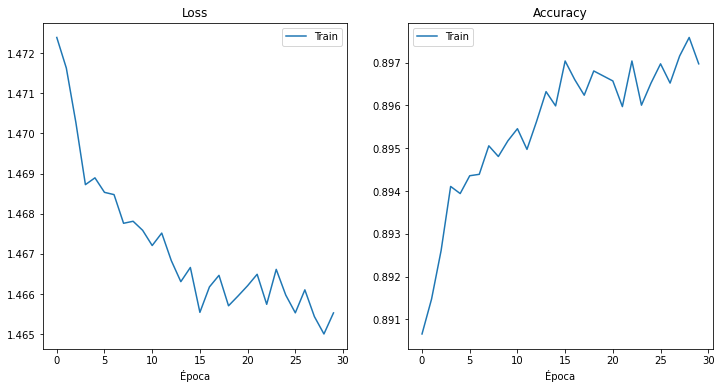

In [20]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(losses, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(accs, label = "Train")
plt.xlabel("Época")
plt.legend()

plt.show()